# Topic Modeling Towards Data Science Blog Posts with Latent Dirichlet Analysis
## bigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [3]:
filename = '../data/cleaned_no_outliers.csv'

In [4]:
#read in the data
df = pd.read_csv(filename)

In [5]:
df.columns

Index(['date', 'title', 'subtitle', 'claps', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 'section_titles',
       'number_paragraphs', 'paragraphs'],
      dtype='object')

In [6]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [7]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [8]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [9]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [10]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [11]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [12]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [13]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [14]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [15]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [19]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [20]:
#!spacy download en_core_web_lg

In [21]:
nlp = spacy.load('en_core_web_lg')

In [22]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [23]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [24]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [25]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [29]:
#check out the dictionary

id2word[0]

'abbreviate'

### Build an LDA Model

Start with standard gensim LDA model

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
doc_lda = lda_model[corpus]

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.232203979273113

Coherence Score:  0.4472422515860178


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.455 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [33]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_LDA_10_bigrams.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011733 -0.011033       1        1  17.920252
3      0.054281 -0.180097       2        1  15.271716
7     -0.004594  0.179027       3        1  11.784854
1     -0.033649  0.001675       4        1  11.420529
8      0.158117  0.204257       5        1   9.896291
5     -0.149477  0.001599       6        1   9.606202
6     -0.074248  0.036955       7        1   8.509386
2     -0.132620 -0.083003       8        1   6.034746
0      0.280724 -0.117673       9        1   4.825952
9     -0.110267 -0.031706      10        1   4.730071, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   60849.000000   60849.000000  Default  30.0000  30.0000
80        data  115227.000000  115227.000000  Default  29.0000  29.0000
940      image   18972.000000   18972.000000  Default  28.0000  28.0000
933   function   25816.000000   25816.000000  Default  27.0000  27.0000
416       word   11384.000000   11384.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
23     article    1499.132529   17525.200639  Topic10  -5.1185   0.5925
1661     state    1283.929170    7442.176408  Topic10  -5.2734   1.2940
1299     score    1242.864252    5310.254222  Topic10  -5.3059   1.5990
327     search    1219.239327    4636.901540  Topic10  -5.3251   1.7154
405     vector    1220.530479    5860.203052  Topic10  -5.3241   1.4823

[745 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1124      2  0.033898  accuracy
1124      4  0.958095  accuracy
1124      6  0.007903  accuracy
2300      1  0.012201    action
2300      2  0.211756    action
...     ...       ...       ...
420       1  0.320856      year
420       2  0.556151      year
420       3  0.044176      year
420       6  0.020809      year
420       8  0.057894      year

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 9, 6, 7, 3, 1, 10])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [34]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [35]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [36]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.47334305972047197


Coherence score has improved for this 10 topic model using the MALLET algorithm. Let's next visualize the topic spread.

In [26]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [38]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.112306 -0.192075       1        1  11.067871
1     -0.059112  0.101273       2        1   8.632542
2     -0.201435 -0.015683       3        1   9.487799
3      0.107987 -0.167969       4        1  12.582845
4     -0.110058 -0.225680       5        1   9.181223
5      0.068150  0.148249       6        1  11.032672
6      0.034251  0.061788       7        1   7.286298
7      0.277832  0.099369       8        1  10.927703
8     -0.122215  0.109309       9        1  10.591854
9     -0.107706  0.081417      10        1   9.209194, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   66279.000000   66279.000000  Default  30.0000  30.0000
80        data  126220.000000  126220.000000  Default  29.0000  29.0000
940      image   19748.000000   19748.000000  Default  28.0000  28.0000
933   function   29302.000000   29302.000000  Default  27.0000  27.0000
572    feature   21113.000000   21113.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
858     update    1907.374166    4845.486135  Topic10  -5.5439   1.4526
338     simple    2158.314111   11570.040109  Topic10  -5.4203   0.7059
488       call    2134.140959   11174.899960  Topic10  -5.4315   0.7294
331        set    2168.674066   19672.922482  Topic10  -5.4155   0.1798
971  parameter    2045.506142    9063.564936  Topic10  -5.4740   0.8964

[966 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
423       7  0.968014      abcd
6798      4  0.999946  academia
1555      1  0.297367    access
1555      5  0.000413    access
1555      6  0.162819    access
...     ...       ...       ...
420       3  0.022182      year
420       4  0.328926      year
420       5  0.493635      year
420       6  0.034069      year
420       7  0.000123      year

[1862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model, but there's a lot of overlap. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using 
1) coherence score 
2) qualitative evaluation of topic spread/overlap 

as my evaluation metrics.

#### Compute Optimal Number of Topics Based on Coherence

In [39]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_big.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_big.pkl')

    return model_list, coherence_values, num_topics_list

In [40]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [41]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_big.pkl')
joblib.dump(optimal_model,f'stored_models/optimal_ldamallet_model_big.pkl')

['stored_models/optimal_ldamallet_model_big.pkl']

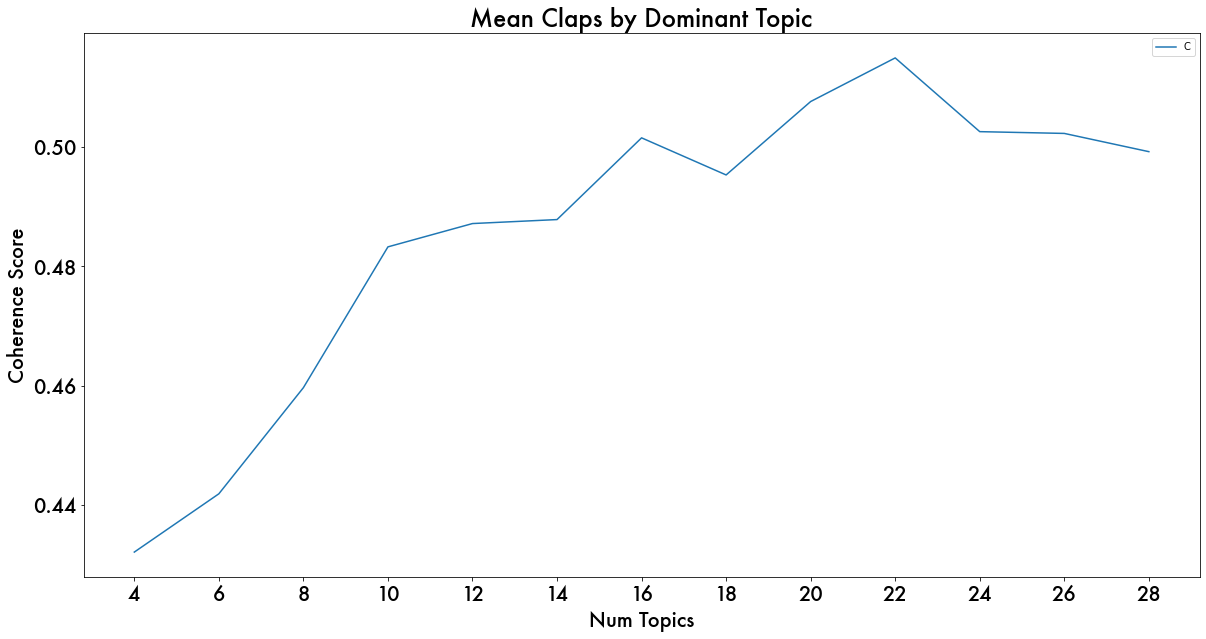

In [42]:
# Show coherence values graph

limit=30; start=4; step=2;
x = range(start, limit, step)
plt.figure(figsize = (20, 10));
sns.lineplot(x=x, y=coherence_values);
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(ticks=range(4,30,2), **figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Num Topics',**figurefont, fontsize = 20);
plt.ylabel('Coherence Score',**figurefont, fontsize = 20);
plt.legend('Coherence Values', loc='best')

plt.savefig('../figures/tds_coherence_bigrams.jpg',  bbox_inches = "tight")

The coherence is highest at 22 topics, followed by 16, and with 12 and 10 close behind.

### Create & Visualize Model with Optimal Number of Topics

In [43]:
optimal_model = joblib.load('stored_models/optimal_ldamallet_model_big.pkl')

#### LDA Mallet Model: 22 Topics

In [44]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.514920708296126


In [47]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model22_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.133438 -0.136513       1        1  4.192109
1      0.006915  0.163146       2        1  4.194468
2      0.138480 -0.069546       3        1  4.817760
3     -0.063720 -0.017377       4        1  5.363672
4      0.195799  0.169717       5        1  4.913115
5      0.178758 -0.037854       6        1  5.317016
6      0.081952 -0.248229       7        1  4.255241
7     -0.087550 -0.118886       8        1  3.866554
8     -0.186144  0.091490       9        1  4.892629
9     -0.026828  0.114689      10        1  3.488377
10    -0.127283 -0.193770      11        1  4.898983
11    -0.179226  0.053201      12        1  4.269457
12     0.141444  0.018441      13        1  6.129026
13    -0.120601  0.007271      14        1  4.636022
14     0.257752  0.073277      15        1  5.495808
15    -0.154081  0.154581      16        1  4.910798
16     0.099830  0.021269      17        1  4.761744
17    -0.064056 -0.016209      18        1  4.096131
18     0.080571  0.044302      19        1  3.133225
19    -0.118068  0.110348      20        1  4.073595
20     0.053577 -0.293666      21        1  4.850107
21     0.025918  0.110317      22        1  3.444162, topic_info=         Term           Freq          Total Category  logprob  loglift
80       data  126745.000000  126745.000000  Default  30.0000  30.0000
242     model   65841.000000   65841.000000  Default  29.0000  29.0000
933  function   29361.000000   29361.000000  Default  28.0000  28.0000
940     image   19343.000000   19343.000000  Default  27.0000  27.0000
572   feature   21095.000000   21095.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
794   similar     981.600079    6997.261126  Topic22  -5.2247   1.4044
335      show    1080.224204   14992.614586  Topic22  -5.1289   0.7381
253    number    1117.353327   19578.906276  Topic22  -5.0951   0.5050
275      post     899.219929    7013.016207  Topic22  -5.3123   1.3145
761    result     920.105077   18189.482670  Topic22  -5.2894   0.3844

[2163 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
17740      5  0.982175              accent
17740     19  0.015842              accent
1555       2  0.008410              access
1555       3  0.132719              access
1555       5  0.115488              access
...      ...       ...                 ...
2285       2  1.002460              yearly
3608       2  0.988044  yearly_seasonality
17352     14  0.999671               yolov
1343       9  1.062167              youden
6724       8  0.965933              zorder

[5312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

Decent distribution across the space but more overlap of topics than is optimal. I will explore the other peaks. 

#### LDA Mallet Model: 16 Topics

In [49]:
ldamallet_model = joblib.load('stored_models/ldamallet_model16_big.pkl')

In [50]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5015203148743821


In [51]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model16_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.188096 -0.056744       1        1  6.869606
1     -0.034437 -0.096823       2        1  4.833515
2     -0.255980 -0.137046       3        1  5.934345
3      0.091536  0.180473       4        1  5.914677
4      0.082151  0.051869       5        1  5.196261
5     -0.091024  0.178304       6        1  9.130893
6     -0.071010  0.212562       7        1  7.122510
7      0.133780 -0.063506       8        1  7.356113
8      0.110740 -0.106591       9        1  6.815355
9     -0.030923 -0.213431      10        1  6.570926
10     0.042623 -0.034005      11        1  5.717244
11    -0.236160 -0.076257      12        1  5.847665
12    -0.181895  0.045669      13        1  5.415335
13     0.012858  0.233189      14        1  6.718468
14     0.203697 -0.062711      15        1  5.359122
15     0.035946 -0.054952      16        1  5.197964, topic_info=             Term           Freq          Total Category  logprob  loglift
80           data  126931.000000  126931.000000  Default  30.0000  30.0000
242         model   65903.000000   65903.000000  Default  29.0000  29.0000
933      function   29218.000000   29218.000000  Default  28.0000  28.0000
50           code   26639.000000   26639.000000  Default  27.0000  27.0000
940         image   19375.000000   19375.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
292      question    1428.487143    9404.553526  Topic16  -5.2611   1.0723
761        result    1544.001411   18183.134435  Topic16  -5.1833   0.4908
1205     generate    1353.002714    7792.865512  Topic16  -5.3153   1.2060
183   information    1373.589411   10948.128497  Topic16  -5.3002   0.8812
150          give    1315.260371   16053.935140  Topic16  -5.3436   0.4550

[1547 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1555       3  0.423834  access
1555       4  0.027628  access
1555       7  0.113582  access
1555      10  0.126065  access
1555      13  0.204856  access
...      ...       ...     ...
2285       4  1.002532  yearly
1817       1  0.879271   ymean
12778      9  0.999393    yolo
1343      15  1.040428  youden
2906       2  0.868311   ¹note

[3433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

#### LDA Mallet Model: 12 Topics

In [52]:
ldamallet_model = joblib.load('stored_models/ldamallet_model12_big.pkl')

In [53]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48715121894302876


In [54]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model12_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.276508  0.058613       1        1   7.072346
1     -0.003187 -0.281487       2        1   8.540469
2     -0.030497  0.222174       3        1   7.959856
3      0.173247  0.055939       4        1   8.234438
4     -0.245985  0.128636       5        1   7.697962
5     -0.079372 -0.164331       6        1  11.119814
6     -0.071740 -0.124304       7        1   7.860842
7      0.134548  0.044241       8        1   9.153259
8      0.039106  0.021681       9        1   6.675741
9      0.069312 -0.129662      10        1   7.570626
10     0.115176  0.088541      11        1   8.361350
11     0.175900  0.079959      12        1   9.753296, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126868.000000  126868.000000  Default  30.0000  30.0000
242      model   65928.000000   65928.000000  Default  29.0000  29.0000
50        code   26598.000000   26598.000000  Default  28.0000  28.0000
933   function   29400.000000   29400.000000  Default  27.0000  27.0000
940      image   19469.000000   19469.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
205      learn    4243.916141   25203.880219  Topic12  -4.8015   0.5461
761     result    3340.119096   18161.467652  Topic12  -5.0410   0.6343
279    problem    3066.173143   15878.120486  Topic12  -5.1266   0.6831
958     method    2692.304411   15080.312452  Topic12  -5.2566   0.6046
1695     build    2569.926959   12207.633658  Topic12  -5.3031   0.7694

[1151 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6798      6  0.998551  academia
1555      1  0.489818    access
1555      2  0.133014    access
1555      3  0.142762    access
1555      5  0.066203    access
...     ...       ...       ...
420       7  0.036440      year
420       9  0.011128      year
420      10  0.441564      year
1817      8  0.879939     ymean
1343     12  1.068824    youden

[2423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#### LDA Mallet Model: 10 Topics

In [30]:
ldamallet_model = joblib.load('stored_models/ldamallet_model10_big.pkl')

In [31]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4832437065285789


In [32]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(ldamallet_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/tds_optimal_LDA_mallet_model10_big.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.140146 -0.105498       1        1  10.985473
1     -0.147036 -0.033484       2        1   9.499453
2      0.101556  0.280839       3        1  10.102245
3      0.019076 -0.166349       4        1   9.555543
4     -0.162476 -0.073160       5        1  10.996632
5     -0.126761  0.194784       6        1  10.069180
6      0.232997 -0.154562       7        1  10.595646
7     -0.075147  0.004518       8        1   7.511341
8      0.183372 -0.028509       9        1  12.124471
9      0.114565  0.081421      10        1   8.560015, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  127320.000000  127320.000000  Default  30.0000  30.0000
242      model   66421.000000   66421.000000  Default  29.0000  29.0000
940      image   19568.000000   19568.000000  Default  28.0000  28.0000
933   function   29302.000000   29302.000000  Default  27.0000  27.0000
322    science   17476.000000   17476.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
1318    system    1969.189652    9779.954309  Topic10  -5.4389   0.8554
906     create    2232.358617   24766.854347  Topic10  -5.3135   0.0516
331        set    2053.861483   19686.781638  Topic10  -5.3968   0.1978
394       type    1857.056984   11359.400799  Topic10  -5.4975   0.6470
288    provide    1781.538836   11187.718666  Topic10  -5.5390   0.6207

[951 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
423       8  0.971185      abcd
425       7  1.031081   acclaim
1124      2  0.127925  accuracy
1124      5  0.872132  accuracy
2300      1  0.590799    action
...     ...       ...       ...
420       4  0.482378      year
420       7  0.153851      year
420       9  0.327302      year
420      10  0.036625      year
1817      1  0.880322     ymean

[1880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

This model provides the best balance of spread, disambiguation, and coherence score. 

In [58]:
pyLDAvis.save_html(plot, '../figures/tds_final_LDA_mallet_model10_big.html')


### Find the Dominant Topic in Each Document

In [33]:
pd.set_option('max_colwidth', 100)

In [34]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [35]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)

df_dominant_topic=pd.DataFrame()
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to match df
df_dominant_topic.index = df.index


In [36]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.6300,"data, science, learn, work, scientist, project, time, good, machine, start","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,7.0,0.4035,"word, text, model, language, topic, document, article, task, sentence, nlp","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,1.0,0.4125,"image, network, layer, model, training, input, deep, learning, learn, output","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,5.0,0.4728,"function, python, column, code, create, data, list, method, plot, panda","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,4.0,0.6027,"model, data, feature, dataset, prediction, machine, predict, learning, training, set","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


#### Find the most representative document for each topic

In [37]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to match df numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [38]:
# Show topics and keywords
doc_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
329,0.0,0.8733,"probability, distribution, number, function, algorithm, state, sample, variable, give, problem","[ultimate, guide, hypothesis, testing, confidence_interval, different, get, ultimate, guide, hyp..."
7773,1.0,0.8215,"image, network, layer, model, training, input, deep, learning, learn, output","[paper, read, deep, image, inpainte, paper, read, deep, image, inpainte, image, inpainte, termin..."
1218,2.0,0.8169,"file, code, create, run, python, project, follow, api, app, command","[publish, python, package, pypi, publish, python, packageshow, publish, python, package, pypi, p..."
3798,3.0,0.8025,"data, time, analysis, show, year, high, number, day, average, price","[exploratory, data, analysis, sao_paulo, policy, murder, report, accord, world, health, explorat..."
8515,4.0,0.7814,"model, data, feature, dataset, prediction, machine, predict, learning, training, set","[mustknow, classification, metric, machine, learning, evaluate, classification, model, mustknow,..."
8693,5.0,0.8661,"function, python, column, code, create, data, list, method, plot, panda","[useful, thing, know, python, extremely, useful, function, expression, know, python, useful, thi..."
8709,6.0,0.8163,"system, ai, business, product, company, team, decision, technology, human, world","[principle, responsible, ai, corporate, responsible, ai, part, principle, responsible, ai, corpo..."
1939,7.0,0.7161,"word, text, model, language, topic, document, article, task, sentence, nlp","[text, preprocessing, stop, word, removal, different, library, handy, guide, english, stop, text..."
1540,8.0,0.8265,"data, science, learn, work, scientist, project, time, good, machine, start","[develop, communication, skill, technical, job, learn, effectively, communicate, develop, commun..."
2522,9.0,0.7241,"data, table, database, query, sql, graph, store, tool, node, time","[augment, data, lake, analytic, snowflake, recommendation, snowflake, power, data, lakeaugment, ..."


#### Explore Relationship Between Dominant Topic and Number of Claps

In [39]:
df.head()

,claps,text
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...


In [40]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.6300,"data, science, learn, work, scientist, project, time, good, machine, start","[ultimate, guide, ace, code, interview, data, scientist, data, science, ultimate, guide, ace, co..."
1,1,7.0,0.4035,"word, text, model, language, topic, document, article, task, sentence, nlp","[shakespeare, eminem, well, lyricist, know, poetry, writing, life, shakespeare, eminem, well, ly..."
2,2,1.0,0.4125,"image, network, layer, model, training, input, deep, learning, learn, output","[implement, pytorch, guy, happy, new, year, today, implement, implement, vision, transformer_vit..."
3,3,5.0,0.4728,"function, python, column, code, create, data, list, method, plot, panda","[stock_price, analysis, panda, altair, practical, guide, panda, altairstock, price, analysis, pa..."
4,4,4.0,0.6027,"model, data, feature, dataset, prediction, machine, predict, learning, training, set","[optimal, threshold, imbalanced, classification, handson, tutorialoptimal, threshold, imbalanced..."


In [41]:
#merge on index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [42]:
combined_df.columns

Index(['claps', 'text', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text'],
      dtype='object')

In [43]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [44]:
combined_df.head()

,claps,text,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,8.0,0.6300,"data, science, learn, work, scientist, project, time, good, machine, start"
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,7.0,0.4035,"word, text, model, language, topic, document, article, task, sentence, nlp"
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,1.0,0.4125,"image, network, layer, model, training, input, deep, learning, learn, output"
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,5.0,0.4728,"function, python, column, code, create, data, list, method, plot, panda"
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,4.0,0.6027,"model, data, feature, dataset, prediction, machine, predict, learning, training, set"


In [45]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [46]:
#colum order
new_column_order = combined_df.groupby('Dominant_Topic')['claps'].mean().sort_values().index

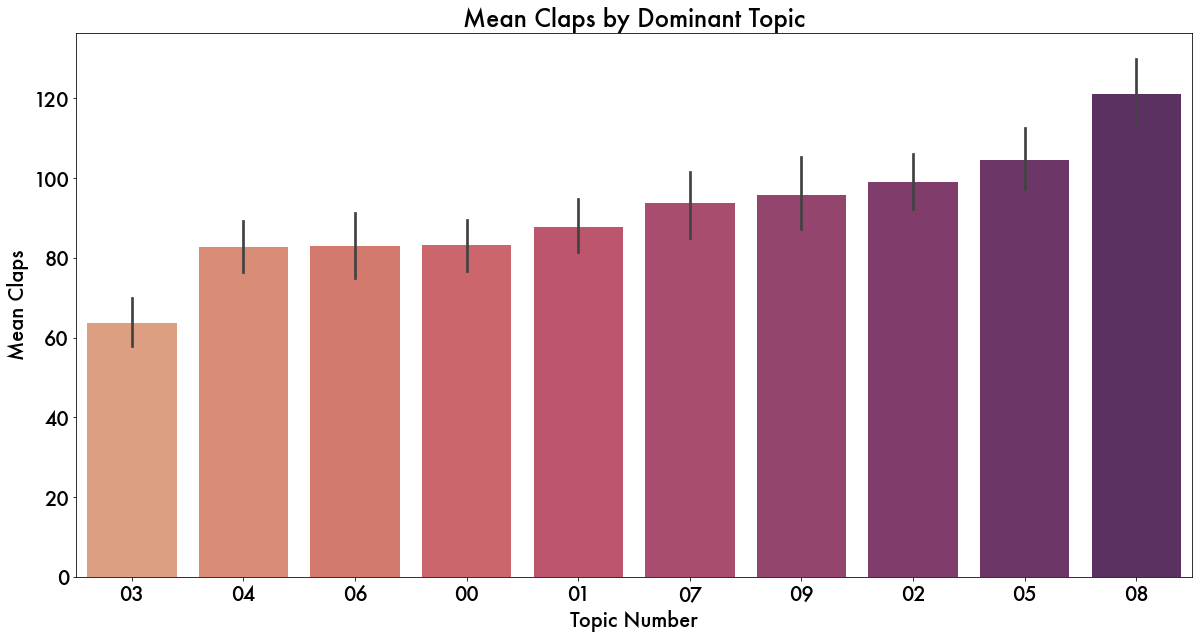

In [47]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='claps', order= new_column_order,  palette='flare');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Claps by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_mean_claps_bigram_model10.jpg',  bbox_inches = "tight")

In [48]:
combined_df['Dominant_Topic'].value_counts()

08    1174
02    1127
05    1061
01    1000
04     961
00     958
03     842
06     743
07     712
09     712
Name: Dominant_Topic, dtype: int64

There is good distribution of the topics across the corpus. 

#### Model Claps by Topic

In [49]:
model_df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [50]:
model_df.columns

Index(['claps', 'text', 'Topic_Perc_Contrib', 'Keywords', 'Dominant_Topic_01',
       'Dominant_Topic_02', 'Dominant_Topic_03', 'Dominant_Topic_04',
       'Dominant_Topic_05', 'Dominant_Topic_06', 'Dominant_Topic_07',
       'Dominant_Topic_08', 'Dominant_Topic_09'],
      dtype='object')

In [51]:
import statsmodels.api as sm

In [52]:
model_df.head()

,claps,text,Topic_Perc_Contrib,Keywords,Dominant_Topic_01,Dominant_Topic_02,Dominant_Topic_03,Dominant_Topic_04,Dominant_Topic_05,Dominant_Topic_06,Dominant_Topic_07,Dominant_Topic_08,Dominant_Topic_09
0,489,the ultimate guide to acing coding interviews for data scientists data science interviewthe ulti...,0.6300,"data, science, learn, work, scientist, project, time, good, machine, start",0,0,0,0,0,0,0,1,0
1,139,shakespeare versus eminem— who’s the better lyricist he is known for his poetry his writings on ...,0.4035,"word, text, model, language, topic, document, article, task, sentence, nlp",0,0,0,0,0,0,1,0,0
2,133,implementing visualttransformer in pytorch hi guys happy new year today we are going to implemen...,0.4125,"image, network, layer, model, training, input, deep, learning, learn, output",1,0,0,0,0,0,0,0,0
3,92,stock price analysis with pandas and altair practical guide for pandas and altairstock price ana...,0.4728,"function, python, column, code, create, data, list, method, plot, panda",0,0,0,0,1,0,0,0,0
4,58,optimal threshold for imbalanced classification handson tutorialoptimal threshold for imbalanced...,0.6027,"model, data, feature, dataset, prediction, machine, predict, learning, training, set",0,0,0,1,0,0,0,0,0


In [53]:
X = model_df.drop(columns=['text','claps','Keywords', 'Topic_Perc_Contrib'])
X = sm.add_constant(X, prepend=True)
y = model_df['claps']

In [54]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  claps   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     17.98
Date:                Wed, 12 May 2021   Prob (F-statistic):           5.80e-30
Time:                        09:10:06   Log-Likelihood:                -57269.
No. Observations:                9290   AIC:                         1.146e+05
Df Residuals:                    9280   BIC:                         1.146e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                83.2745      3.720     22.385      0.000      75.982      90.567
Dominant_Topic_01     4.5765      5.205      0.879      0.379      -5.627      14.780
Dominant_Topic_02    15.8453      5.060      3.132      0.002       5.927      25.764
Dominant_Topic_03   -19.6760      5.439     -3.617      0.000     -30.338      -9.014
Dominant_Topic_04    -0.4317      5.257     -0.082      0.935     -10.736       9.873
Dominant_Topic_05    21.3579      5.132      4.162      0.000      11.299      31.417
Dominant_Topic_06    -0.3755      5.629     -0.067      0.947     -11.409      10.658
Dominant_Topic_07    10.4783      5.697      1.839      0.066      -0.690      21.646
Dominant_Topic_08    37.9376      5.013      7.568      0.000      28.111      47.764
Dominant_Topic_09    12.5092      5.697      2.196      0.028       1.341      23.677
==============================================================================
Omnibus:                     4595.359   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26425.154
Skew:                           2.381   Prob(JB):                         0.00
Kurtosis:                       9.752   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As one might expect, there is quite a bit more going on influencing claps beyond just the dominant topic in an abstract. 